In [326]:
import pandas as pd
import numpy as np
import re
pd.set_option('display.float_format', lambda x: '%.0f' % x)
pd.set_option('display.max_columns', 500)

import gspread
from oauth2client.service_account import ServiceAccountCredentials
from df2gspread import df2gspread as d2g


In [309]:
def upload_to_gsheets(df, sheet_name): 
    scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
    credentials = ServiceAccountCredentials.from_json_keyfile_name('data/key.json', scope)
    gc = gspread.authorize(credentials)

    spreadsheet_key = '1m9FORwuT65rdKjcVT1KtfA5kYZxxWcPgSurXmr6zlKk'
    wks_name = sheet_name
    d2g.upload(df, spreadsheet_key, wks_name, credentials=credentials, row_names=True)
    return 'Data Uploaded'


In [159]:
data = pd.read_excel('data/data_source.xlsx')

In [321]:
#Rename MSISDN Column for easy usage 
data = data.rename(columns={'MSISDN/Number': 'MSISDN', 'Dur. (ms).1': 'Dur', 'Total UL (Bytes)': 'Total UL', 
                           'Total DL (Bytes)': 'Total DL', 'Youtube DL (Bytes)': 'Youtube DL',
                           'Youtube UL (Bytes)': 'Youtube UL', 'Netflix DL (Bytes)': 'Netflix DL',
                            'Netflix UL (Bytes)': 'Netflix UL',
                           'Gaming DL (Bytes)': 'Gaming DL', 'Gaming UL (Bytes)': 'Gaming UL',
                           'Other DL (Bytes)': 'Other DL', 'Other UL (Bytes)': 'Other UL',
                           'Social Media DL (Bytes)':'Social Media DL', 'Social Media UL (Bytes)':'Social Media UL',
                           'Google DL (Bytes)': 'Google DL', 'Google UL (Bytes)': 'Google UL', 
                            'Email DL (Bytes)':'Email DL', 'Email UL (Bytes)':'Email UL'})

In [284]:
data = data.dropna(subset=['MSISDN', 'IMSI', 'IMEI'])
data = data.drop(columns=['Dur'])

In [ ]:
#Replace Outliers with mean
low_bound = data.quantile(0.01)
upper_bound = data.quantile(0.99)


In [174]:
#data.isnull().sum()

#replace null values with the mean in each column
data = data.fillna(data.mean())
data[['Bearer Id','MSISDN','IMSI', 'IMEI', 'Last Location Name' ]] = data[['Bearer Id','MSISDN','IMSI', 'IMEI', 'Last Location Name' ]].astype(str)
data['Last Location Name'].fillna(data['Last Location Name'].mode()[0], inplace=True)


In [286]:
data.head()

,Bearer Id,Start,Start ms,End,End ms,IMSI,MSISDN,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur,Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL,Social Media UL,Google DL,Google UL,Email DL,Email UL,Youtube DL,Youtube UL,Netflix DL,Netflix UL,Gaming DL,Gaming UL,Other DL,Other UL,Total UL,Total DL
0,13114483460844900352,2019-04-04 12:01:18,770,2019-04-25 14:35:31,662,208201448079117.0,33664962239.0,35521209507511.0,9164566995485190,42,5,23,44,20884183,766247,100,0,0,0,100,0,0,0,115512385,3269792,37624,38787,1823652892,Samsung,Samsung Galaxy A5 Sm-A520F,994,343,816,150,971,142,213,214,1545765,24420,1634479,1271433,3563542,137762,15854611,2501332,8198936,9656251,278082303,14344150,171744450,8814393,36749741,308879636
1,13114483482878900224,2019-04-09 13:04:04,235,2019-04-25 08:15:48,606,208201909211140.0,33681854413.0,35794009006359.0,L77566A,65,5,16,26,20884183,766247,100,0,0,0,100,0,0,0,115512385,3269792,168,3560,1365104371,Samsung,Samsung Galaxy J5 (Sm-J530),994,343,816,150,971,142,971,1022,1926113,7165,3493924,920172,629046,308339,20247395,19111729,18338413,17227132,608750074,1170709,526904238,15055145,53800391,653384965
2,13114483484080500736,2019-04-09 17:42:11,1,2019-04-25 11:58:13,652,208200314458056.0,33760627129.0,35281510359387.0,D42335A,108,18,6,9,20884183,766247,100,0,0,0,100,0,0,0,115512385,3269792,0,0,1361762651,Samsung,Samsung Galaxy A8 (2018),994,343,816,150,971,142,751,695,1684053,42224,8535055,1694064,2690151,672973,19725661,14699576,17587794,6163408,229584621,395630,410692588,4215763,27883638,279807335
3,13114483485442799616,2019-04-10 00:31:25,486,2019-04-25 07:36:35,171,208201402342131.0,33750343200.0,35356610164913.0,T21824A,108,18,44,44,20884183,766247,100,0,0,0,100,0,0,0,115512385,3269792,3330,37882,1321509685,undefined,undefined,994,343,816,150,971,142,17,207,644121,13372,9023734,2788027,1439754,631229,21388122,15146643,13994646,1097942,799538153,10849722,749039933,12797283,43324218,846028530
4,13114483499480700928,2019-04-12 20:10:23,565,2019-04-25 10:40:32,954,208201401415120.0,33699795932.0,35407009745539.0,D88865A,108,18,6,9,20884183,766247,100,0,0,0,100,0,0,0,115512385,3269792,0,0,1089009389,Samsung,Samsung Sm-G390F,994,343,816,150,971,142,607,604,862600,50188,6248284,1500559,1936496,173853,15259380,18962873,17124581,415218,527707248,3529801,550709500,13910322,38542814,569138589


In [219]:
top10_handsets = data['Handset Type'].value_counts()[:10]
top10_handsets

Huawei B528S-23A                19727
Apple iPhone 6S (A1688)          9413
Apple iPhone 6 (A1586)           9012
undefined                        8931
Apple iPhone 7 (A1778)           6304
Apple iPhone Se (A1723)          5176
Apple iPhone 8 (A1905)           4985
Apple iPhone Xr (A2105)          4562
Samsung Galaxy S8 (Sm-G950F)     4480
Apple iPhone X (A1901)           3810
Name: Handset Type, dtype: int64

In [225]:
top3_mfr = data.groupby('Handset Manufacturer')['Handset Type'].count().sort_values(ascending=False)[:3]

Handset Manufacturer
Apple      59464
Samsung    40579
Huawei     34366
Name: Handset Type, dtype: int64

In [266]:
data['Handset Type'].value_counts()

Huawei B528S-23A                                  19727
Apple iPhone 6S (A1688)                            9413
Apple iPhone 6 (A1586)                             9012
undefined                                          8931
Apple iPhone 7 (A1778)                             6304
                                                  ...  
Rim Blackberry Stl100-1 Z10 Rfg81Uw                   1
Shenzhen Kelly T. Kliton Kailitong F168               1
Samsung Galaxy J5 Prime Dual-Sim (Sm-G570F Ds)        1
Quectel Wireless. Quectel Ec21-E                      1
A-Link Telecom I. Cubot Nova                          1
Name: Handset Type, Length: 1394, dtype: int64

In [283]:
data.groupby(['Handset Manufacturer', 'Handset Type'])['Handset Type'].head(3)


0                                Samsung Galaxy A5 Sm-A520F
1                               Samsung Galaxy J5 (Sm-J530)
2                                  Samsung Galaxy A8 (2018)
3                                                 undefined
4                                          Samsung Sm-G390F
                                ...                        
149288               Shenzhen Jeko Co. Blackview Bv5800 Pro
149436                           Xiaomi Communica. Redmi 4A
149488                                        Haier G50 L54
149598                        Tinno Mobile Tec. Tinno S9201
149605    Zte Zte Blade C2 Smartphone Android By Sfr Sta...
Name: Handset Type, Length: 2881, dtype: object

In [369]:
#Information per user
user = data.groupby('MSISDN')
total_xdr = user.agg({'Bearer Id':'count'})
sesh_duration = user.agg({'Dur':'sum'})
total_dl = user.agg({'Total DL':'sum'})
total_ul = user.agg({'Total UL':'sum'})
google_volume = user.agg({'Google DL' : 'sum', 'Google UL': 'sum'}).sum(axis=1).reset_index(name='Google Volume')
social_volume = user.agg({'Social Media DL' : 'sum', 'Social Media UL': 'sum'}).sum(axis=1).reset_index(name='Social Volume')
email_volume = user.agg({'Email DL' : 'sum', 'Email UL': 'sum'}).sum(axis=1).reset_index(name='Email Volume')
youtube_volume = user.agg({'Youtube DL' : 'sum', 'Youtube UL': 'sum'}).sum(axis=1).reset_index(name='Youtube Volume')
netflix_volume = user.agg({'Netflix DL' : 'sum', 'Netflix UL': 'sum'}).sum(axis=1).reset_index(name='Netflix Volume')
gaming_volume = user.agg({'Gaming DL' : 'sum', 'Gaming UL': 'sum'}).sum(axis=1).reset_index(name='Gaming Volume')

SyntaxError: Generator expression must be parenthesized (<ipython-input-376-efdc7f6d33c3>, line 1)

In [390]:
print(f'number of xDR sessions\n{total_xdr.describe()}')
upload_to_gsheets(total_xdr.describe(), 'total_xdr')

print(f'\nSession duration\n{sesh_duration.describe()}')
upload_to_gsheets(sesh_duration.describe(), 'session_duration')

print(f'\ntotal download data (DL)\n{total_dl.describe()}')
upload_to_gsheets(total_dl.describe(), 'total_dl')

print(f'\ntotal upload (UL) data\n{total_ul.describe()}')
upload_to_gsheets(total_ul.describe(), 'total_ul')

print(f'\nGoogle Volume\n{google_volume.describe()}')
upload_to_gsheets(google_volume.describe(), 'google_volume')

print(f'\nSocial Volume\n{social_volume.describe()}')
upload_to_gsheets(social_volume.describe(), 'social_volume')

print(f'\nEmail Volume\n{email_volume.describe()}')
upload_to_gsheets(email_volume.describe(), 'email_volume')

print(f'\nYoutube Volume\n{youtube_volume.describe()}')
upload_to_gsheets(youtube_volume.describe(), 'youtube_volume')

print(f'\nNetflix Volume\n{netflix_volume.describe()}')
upload_to_gsheets(netflix_volume.describe(), 'netflix_volume')

print(f'\nGaming Volume\n{gaming_volume.describe()}')
upload_to_gsheets(gaming_volume.describe(), 'gaming_volume')

number of xDR sessions
       Bearer Id
count     106856
mean           1
std            1
min            1
25%            1
50%            1
75%            2
max           18

Session duration
              Dur
count      106856
mean    146167917
std     186358951
min       7142988
25%      71308343
50%     102740222
75%     172800001
max   18553763486

total download data (DL)
        Total DL
count     106856
mean   633652681
std    464555056
min      8827082
25%    314827064
50%    570367723
75%    807364490
max   8156743493

total upload (UL) data
       Total UL
count    106856
mean   57309422
std    35657650
min     2866892
25%    36395475
50%    46793866
75%    65731993
max   729577380

Google Volume
       Google Volume
count         106856
mean        10882434
std          7544861
min            40330
25%          5942636
50%          9586153
75%         13214740
max        152191852

Social Volume
       Social Volume
count         106856
mean         2547967
std          19

'Data Uploaded'

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1ca8ad7f0>]]


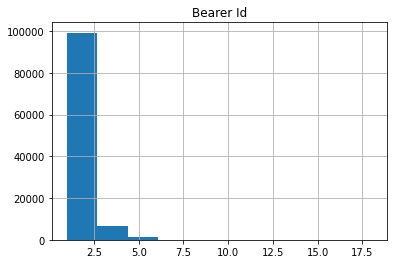

In [387]:
print(total_xdr.hist(bins=10))

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1caaae5c0>]]


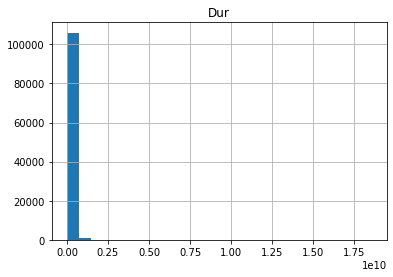

In [389]:
print(sesh_duration.hist(bins=25))